In [1]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
# нам необходима версия pillow  5.3.0
# удалим старую версию и установим новую
#!pip uninstall -y Pillow
#!pip install Pillow==5.3.0
import PIL
print(PIL.PILLOW_VERSION)
# здесь должна быть версия 5.3.0. если это не так перехгрузите данный ноутбук:
# Menu > Runtime > Restart Runtime

6.1.0


In [3]:
!ls train

dataset


In [4]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sat May  9 11:51:53 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 760     On   | 00000000:01:00.0 N/A |                  N/A |
| 32%   29C    P8    N/A /  N/A |     11MiB /  4034MiB |     N/A      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

True

In [5]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [6]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [8]:
class SimpsonsDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        self.files = files
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f'wrong mode: {self.mode}')
            raise NameError

        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump:
                pickle.dump(self.label_encoder, le_dump)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        transform = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                                
        ])

        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')

        x = transform(x)

        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [9]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [10]:
TRAIN_DIR = Path('train/dataset')
TEST_DIR = Path('test/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [11]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]

train_files = train_val_files.copy()

In [12]:
train_dataset = SimpsonsDataset(train_files, mode='train')

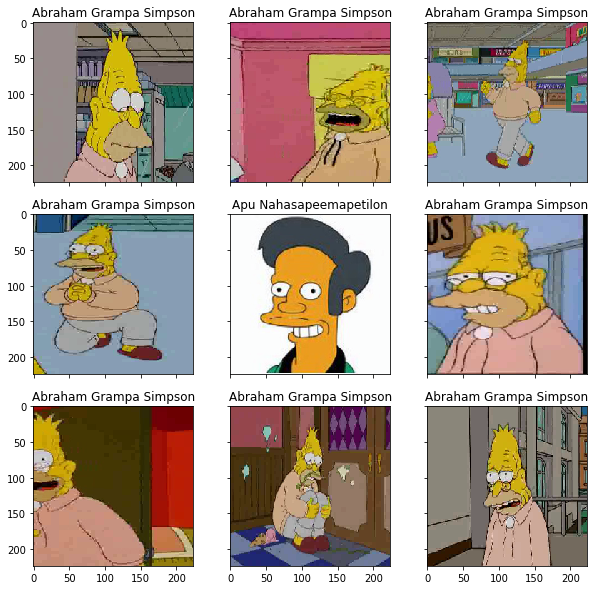

In [13]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,10), sharex=True, sharey=True)

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [14]:
class ConvModel(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=160, kernel_size=3),
            nn.BatchNorm2d(160),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
        )
        self.fc1 = nn.Sequential(
            nn.Linear(5 * 5 * 160, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )        
        self.out = nn.Linear(1024, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(-1, 5 * 5 * 160)
        x = self.fc1(x)
        x = self.fc2(x)

        logits = self.out(x)
        return logits

In [15]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [16]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [17]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
      
        
        opt = torch.optim.Adam(model.parameters())
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            opt, mode='max', factor=0.1, patience=10, verbose=False) # добавлен scheduler
        
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            scheduler.step(val_acc)
            
    return history

In [18]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [19]:
n_classes = len(np.unique(train_val_labels))
conv_model = ConvModel(n_classes).to(DEVICE)
print("we will classify : {}".format(n_classes))
print(conv_model)

/home/nekita473/anaconda3/lib/python3.7/site-packages/torch/cuda/__init__.py:88: UserWarning: 
    Found GPU0 GeForce GTX 760 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


we will classify : 42
ConvModel(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

In [20]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)

In [21]:
import pandas as pd

In [22]:
submit = pd.DataFrame(columns=['Id'])

In [23]:
EPOCHS = 4
BATCH_SIZE = 64

In [24]:
d = {}
for i in train_val_labels:
    if(d.get(i)==None):
        d[i] = 1
    else:
        d[i] += 1

In [25]:
train_val_labels_ = train_val_labels.copy()
train_val_files_ = train_val_files.copy()

In [26]:
for i, j in enumerate(train_val_labels):
    if(d[j]<200):
        for k in range(200 - d[j]):
            train_val_labels_.append(train_val_labels[i])
            train_val_files_.append(train_val_files[i])
            d[j] += 1

In [27]:
d # Операции выше проводились для того, чтобы увеличить до 200 количество картинок, которых в исходной выборке было меньше 200

{'abraham_grampa_simpson': 913,
 'agnes_skinner': 200,
 'apu_nahasapeemapetilon': 623,
 'barney_gumble': 200,
 'bart_simpson': 1342,
 'carl_carlson': 200,
 'charles_montgomery_burns': 1193,
 'chief_wiggum': 986,
 'cletus_spuckler': 200,
 'comic_book_guy': 469,
 'disco_stu': 200,
 'edna_krabappel': 457,
 'fat_tony': 200,
 'gil': 200,
 'groundskeeper_willie': 200,
 'homer_simpson': 2246,
 'kent_brockman': 498,
 'krusty_the_clown': 1206,
 'lenny_leonard': 310,
 'lionel_hutz': 200,
 'lisa_simpson': 1354,
 'maggie_simpson': 200,
 'marge_simpson': 1291,
 'martin_prince': 200,
 'mayor_quimby': 246,
 'milhouse_van_houten': 1079,
 'miss_hoover': 200,
 'moe_szyslak': 1452,
 'ned_flanders': 1454,
 'nelson_muntz': 358,
 'otto_mann': 200,
 'patty_bouvier': 200,
 'principal_skinner': 1194,
 'professor_john_frink': 200,
 'rainier_wolfcastle': 200,
 'ralph_wiggum': 200,
 'selma_bouvier': 200,
 'sideshow_bob': 877,
 'sideshow_mel': 200,
 'snake_jailbird': 200,
 'troy_mcclure': 200,
 'waylon_smithers': 

epoch:   0%|          | 0/4 [00:00<?, ?it/s]


FOLD 1
loss 1.2320756077854915


epoch:  25%|██▌       | 1/4 [06:29<19:27, 389.23s/it]


Epoch 001 train_loss: 1.2321     val_loss 0.8783 train_acc 0.6642 val_acc 0.7482
loss 0.6829454876212505


epoch:  50%|█████     | 2/4 [09:04<10:37, 318.99s/it]


Epoch 002 train_loss: 0.6829     val_loss 0.7427 train_acc 0.8050 val_acc 0.7841
loss 0.3785757669599207


epoch:  75%|███████▌  | 3/4 [11:29<04:26, 266.84s/it]


Epoch 003 train_loss: 0.3786     val_loss 0.5007 train_acc 0.8873 val_acc 0.8668
loss 0.22921779292014638


epoch: 100%|██████████| 4/4 [13:54<00:00, 208.62s/it]


Epoch 004 train_loss: 0.2292     val_loss 0.5749 train_acc 0.9300 val_acc 0.8480


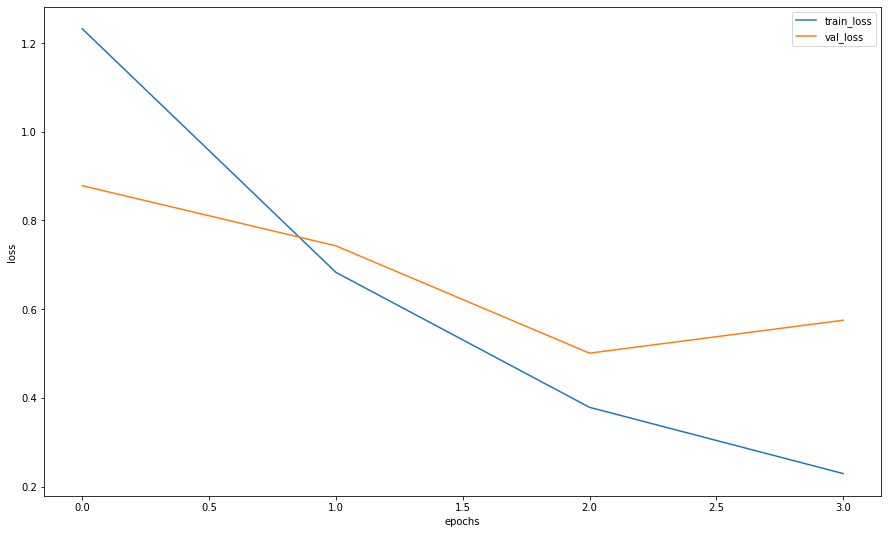

epoch:   0%|          | 0/4 [00:00<?, ?it/s]


FOLD 2
loss 1.2770854607068904


epoch:  25%|██▌       | 1/4 [02:26<07:19, 146.37s/it]


Epoch 001 train_loss: 1.2771     val_loss 0.8246 train_acc 0.6546 val_acc 0.7741
loss 0.7872004677224689


epoch:  50%|█████     | 2/4 [04:51<04:51, 145.92s/it]


Epoch 002 train_loss: 0.7872     val_loss 0.6454 train_acc 0.7774 val_acc 0.8251
loss 0.3921606860536713


epoch:  75%|███████▌  | 3/4 [07:16<02:25, 145.62s/it]


Epoch 003 train_loss: 0.3922     val_loss 0.4905 train_acc 0.8854 val_acc 0.8660
loss 0.22639369494880826


epoch: 100%|██████████| 4/4 [09:41<00:00, 145.26s/it]


Epoch 004 train_loss: 0.2264     val_loss 0.4449 train_acc 0.9314 val_acc 0.8806


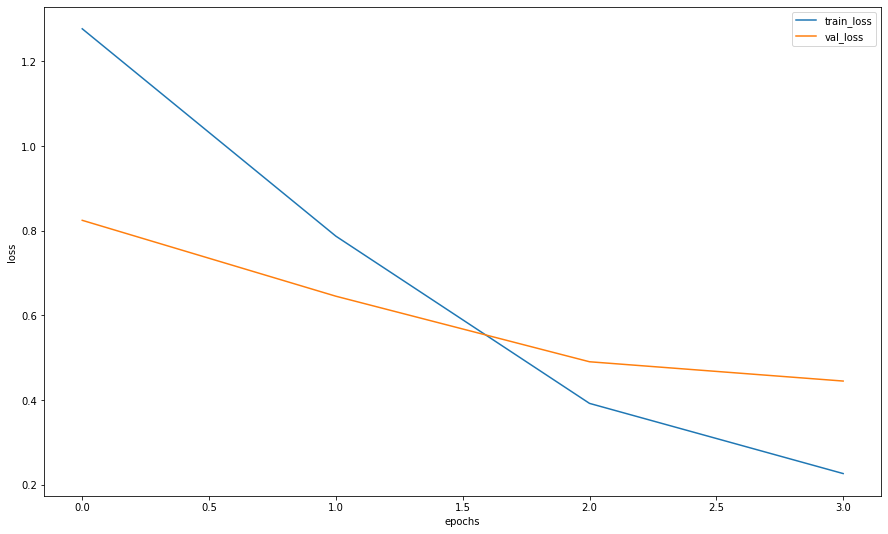

epoch:   0%|          | 0/4 [00:00<?, ?it/s]


FOLD 3
loss 1.2851490483551475


epoch:  25%|██▌       | 1/4 [02:26<07:20, 146.87s/it]


Epoch 001 train_loss: 1.2851     val_loss 0.8893 train_acc 0.6496 val_acc 0.7457
loss 0.7480544091897106


epoch:  50%|█████     | 2/4 [04:52<04:52, 146.40s/it]


Epoch 002 train_loss: 0.7481     val_loss 0.6440 train_acc 0.7849 val_acc 0.8196
loss 0.37604765345042185


epoch:  75%|███████▌  | 3/4 [07:17<02:26, 146.19s/it]


Epoch 003 train_loss: 0.3760     val_loss 0.5619 train_acc 0.8910 val_acc 0.8509
loss 0.22190415524874454


epoch: 100%|██████████| 4/4 [09:43<00:00, 145.86s/it]


Epoch 004 train_loss: 0.2219     val_loss 0.5860 train_acc 0.9321 val_acc 0.8589


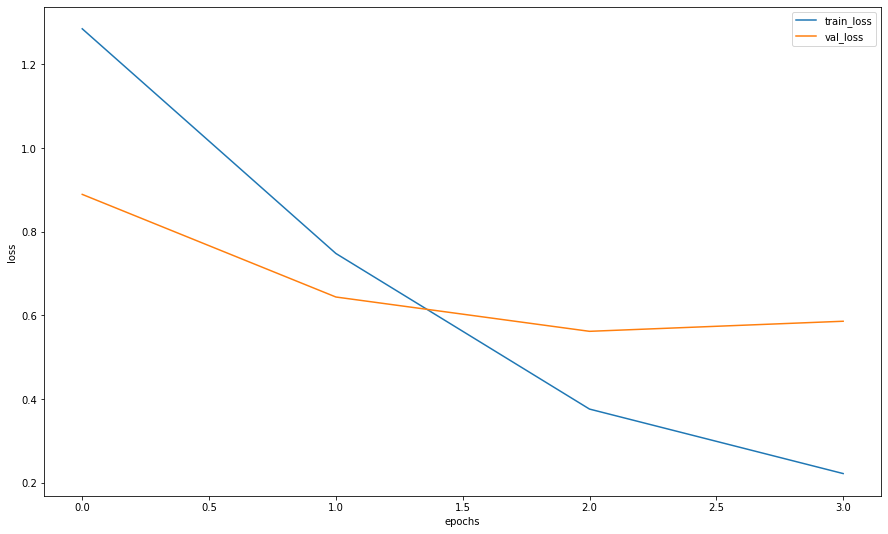

epoch:   0%|          | 0/4 [00:00<?, ?it/s]


FOLD 4
loss 1.2833039383348863


epoch:  25%|██▌       | 1/4 [02:27<07:21, 147.13s/it]


Epoch 001 train_loss: 1.2833     val_loss 1.0415 train_acc 0.6494 val_acc 0.7244
loss 0.7258964891069335


epoch:  50%|█████     | 2/4 [04:52<04:53, 146.63s/it]


Epoch 002 train_loss: 0.7259     val_loss 0.7220 train_acc 0.7912 val_acc 0.8092
loss 0.3819442480997503


epoch:  75%|███████▌  | 3/4 [07:17<02:26, 146.23s/it]


Epoch 003 train_loss: 0.3819     val_loss 0.5941 train_acc 0.8893 val_acc 0.8413
loss 0.2196514044043935


epoch: 100%|██████████| 4/4 [09:43<00:00, 145.82s/it]


Epoch 004 train_loss: 0.2197     val_loss 0.6020 train_acc 0.9329 val_acc 0.8530


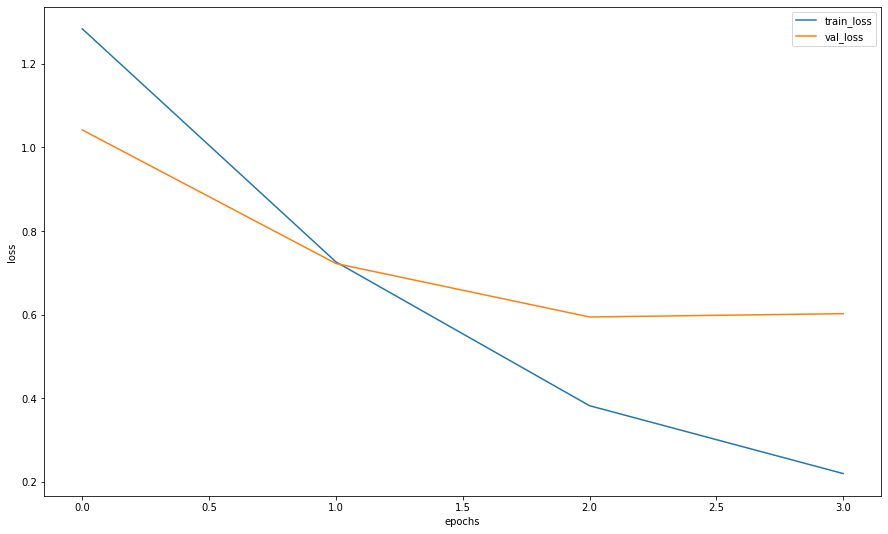

epoch:   0%|          | 0/4 [00:00<?, ?it/s]


FOLD 5
loss 1.2584251437707992


epoch:  25%|██▌       | 1/4 [02:26<07:20, 146.90s/it]


Epoch 001 train_loss: 1.2584     val_loss 0.8906 train_acc 0.6579 val_acc 0.7374
loss 0.7493936460250349


epoch:  50%|█████     | 2/4 [04:52<04:52, 146.47s/it]


Epoch 002 train_loss: 0.7494     val_loss 0.7381 train_acc 0.7869 val_acc 0.8013
loss 0.3904992322263455


epoch:  75%|███████▌  | 3/4 [07:17<02:26, 146.16s/it]


Epoch 003 train_loss: 0.3905     val_loss 0.5425 train_acc 0.8865 val_acc 0.8555
loss 0.21499749293906648


epoch: 100%|██████████| 4/4 [09:42<00:00, 145.67s/it]


Epoch 004 train_loss: 0.2150     val_loss 0.5477 train_acc 0.9345 val_acc 0.8714


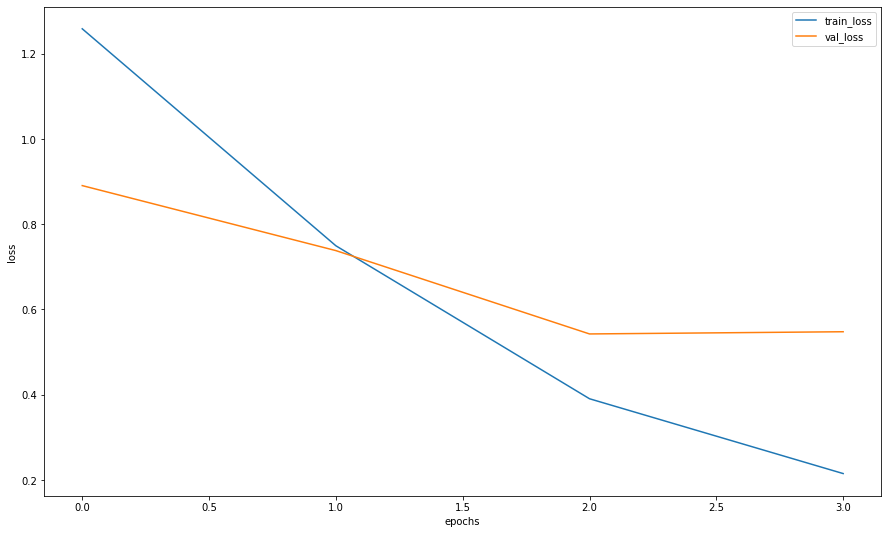

epoch:   0%|          | 0/4 [00:00<?, ?it/s]


FOLD 6
loss 1.2780215982931074


epoch:  25%|██▌       | 1/4 [02:26<07:20, 146.99s/it]


Epoch 001 train_loss: 1.2780     val_loss 1.0198 train_acc 0.6506 val_acc 0.7144
loss 0.7194510176636109


epoch:  50%|█████     | 2/4 [04:52<04:52, 146.40s/it]


Epoch 002 train_loss: 0.7195     val_loss 0.6221 train_acc 0.7936 val_acc 0.8271
loss 0.3863797998502183


epoch:  75%|███████▌  | 3/4 [07:18<02:26, 146.50s/it]


Epoch 003 train_loss: 0.3864     val_loss 0.5109 train_acc 0.8874 val_acc 0.8647
loss 0.22647907834249278


epoch: 100%|██████████| 4/4 [09:44<00:00, 146.01s/it]


Epoch 004 train_loss: 0.2265     val_loss 0.4652 train_acc 0.9327 val_acc 0.8785


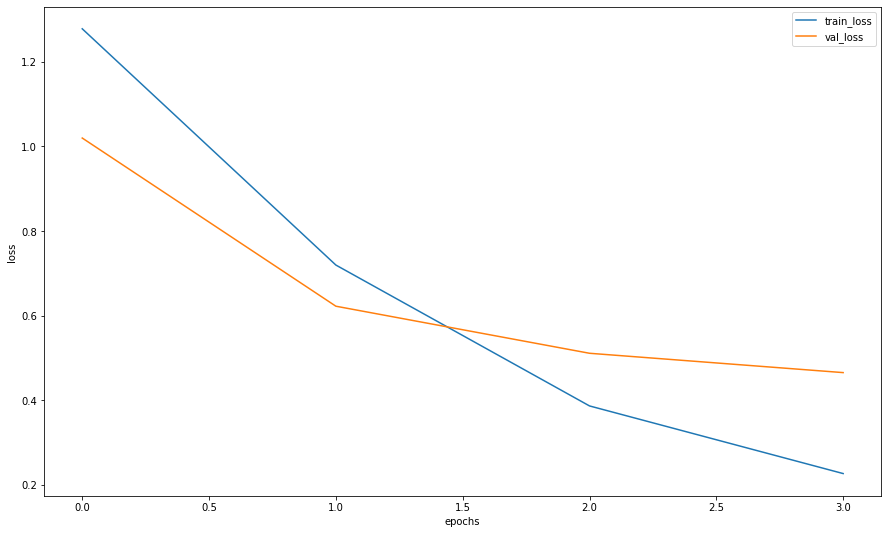

epoch:   0%|          | 0/4 [00:00<?, ?it/s]


FOLD 7
loss 1.2605927595902844


epoch:  25%|██▌       | 1/4 [02:27<07:23, 147.67s/it]


Epoch 001 train_loss: 1.2606     val_loss 0.8770 train_acc 0.6578 val_acc 0.7528
loss 0.6950345122830218


epoch:  50%|█████     | 2/4 [05:07<05:02, 151.28s/it]


Epoch 002 train_loss: 0.6950     val_loss 0.6979 train_acc 0.8019 val_acc 0.8100
loss 0.3605327814663944


epoch:  75%|███████▌  | 3/4 [07:40<02:31, 151.90s/it]


Epoch 003 train_loss: 0.3605     val_loss 0.5494 train_acc 0.8959 val_acc 0.8509
loss 0.20675067183164214


epoch: 100%|██████████| 4/4 [10:12<00:00, 153.14s/it]


Epoch 004 train_loss: 0.2068     val_loss 0.5623 train_acc 0.9379 val_acc 0.8509


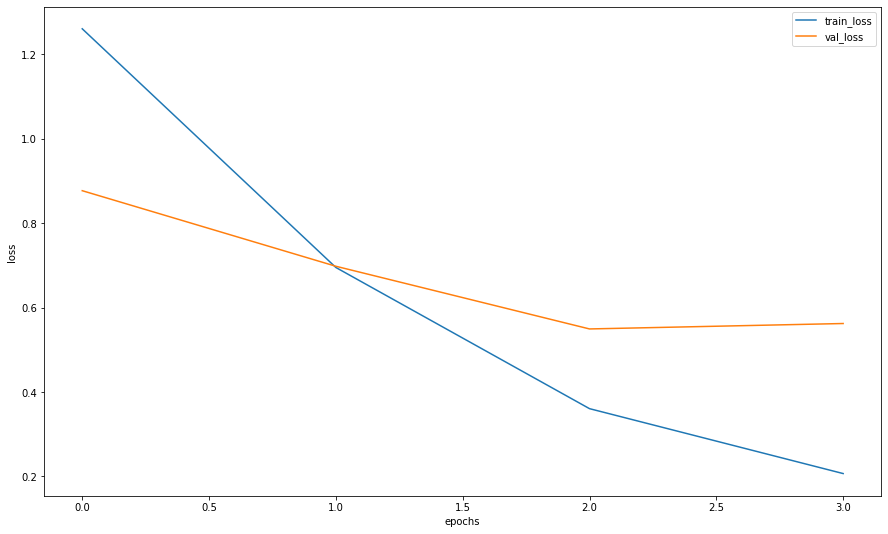

epoch:   0%|          | 0/4 [00:00<?, ?it/s]


FOLD 8
loss 1.2624597131904525


epoch:  25%|██▌       | 1/4 [02:34<07:42, 154.27s/it]


Epoch 001 train_loss: 1.2625     val_loss 0.8873 train_acc 0.6547 val_acc 0.7478
loss 0.6952936389089731


epoch:  50%|█████     | 2/4 [05:00<05:03, 151.78s/it]


Epoch 002 train_loss: 0.6953     val_loss 0.5553 train_acc 0.8012 val_acc 0.8388
loss 0.3715330966427803


epoch:  75%|███████▌  | 3/4 [07:26<02:30, 150.19s/it]


Epoch 003 train_loss: 0.3715     val_loss 0.5307 train_acc 0.8940 val_acc 0.8568
loss 0.2063654099590169


epoch: 100%|██████████| 4/4 [09:52<00:00, 148.13s/it]


Epoch 004 train_loss: 0.2064     val_loss 0.6195 train_acc 0.9380 val_acc 0.8434


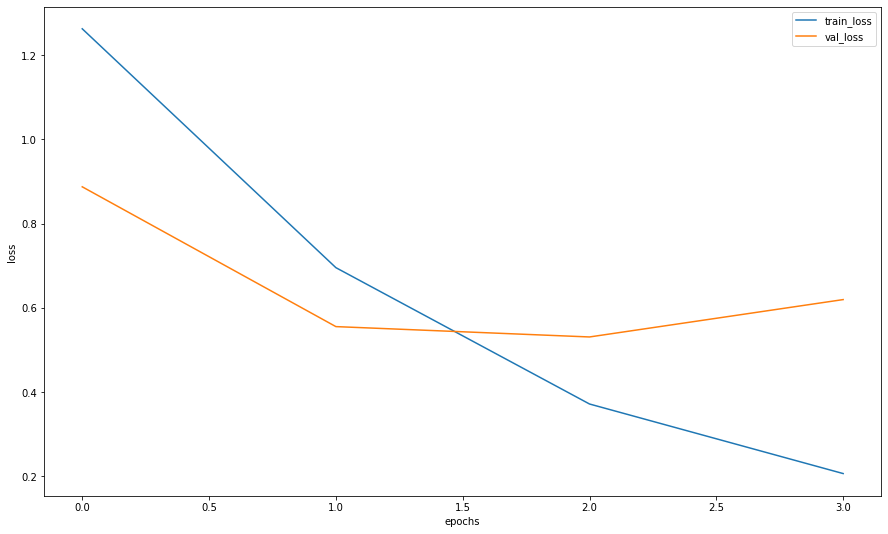

epoch:   0%|          | 0/4 [00:00<?, ?it/s]


FOLD 9
loss 1.248719449304103


epoch:  25%|██▌       | 1/4 [02:27<07:23, 147.87s/it]


Epoch 001 train_loss: 1.2487     val_loss 0.9361 train_acc 0.6618 val_acc 0.7356
loss 0.7083382613419756


epoch:  50%|█████     | 2/4 [04:53<04:54, 147.31s/it]


Epoch 002 train_loss: 0.7083     val_loss 0.6059 train_acc 0.8034 val_acc 0.8287
loss 0.37679668233646163


epoch:  75%|███████▌  | 3/4 [07:21<02:27, 147.42s/it]


Epoch 003 train_loss: 0.3768     val_loss 0.5019 train_acc 0.8908 val_acc 0.8684
loss 0.211517522118967


epoch: 100%|██████████| 4/4 [09:54<00:00, 148.52s/it]


Epoch 004 train_loss: 0.2115     val_loss 0.4966 train_acc 0.9358 val_acc 0.8768


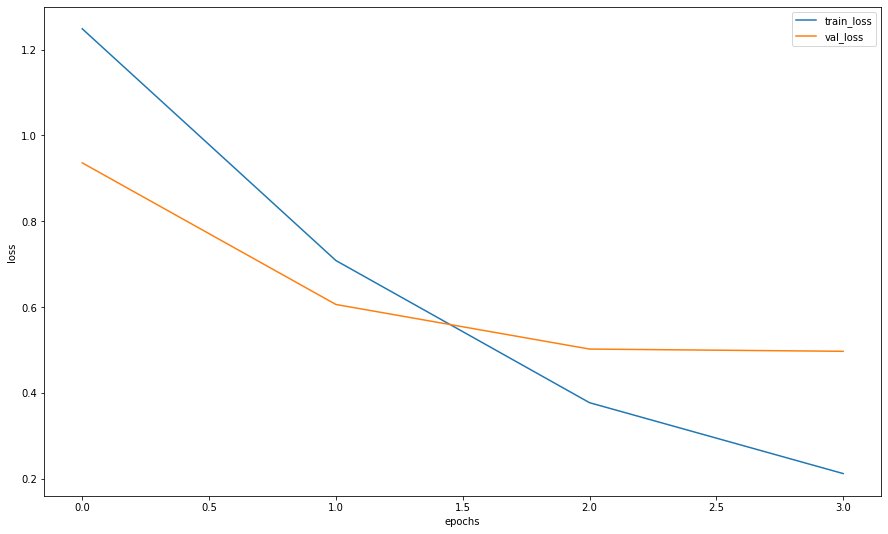

epoch:   0%|          | 0/4 [00:00<?, ?it/s]


FOLD 10
loss 1.226436274087284


epoch:  25%|██▌       | 1/4 [02:32<07:36, 152.10s/it]


Epoch 001 train_loss: 1.2264     val_loss 0.9050 train_acc 0.6680 val_acc 0.7519
loss 0.6891166151947067


epoch:  50%|█████     | 2/4 [04:59<05:01, 150.61s/it]


Epoch 002 train_loss: 0.6891     val_loss 0.7071 train_acc 0.8047 val_acc 0.8087
loss 0.3752419801903001


epoch:  75%|███████▌  | 3/4 [07:29<02:30, 150.56s/it]


Epoch 003 train_loss: 0.3752     val_loss 0.5793 train_acc 0.8885 val_acc 0.8546
loss 0.21119855203123694


epoch: 100%|██████████| 4/4 [09:59<00:00, 149.97s/it]


Epoch 004 train_loss: 0.2112     val_loss 0.5235 train_acc 0.9370 val_acc 0.8768


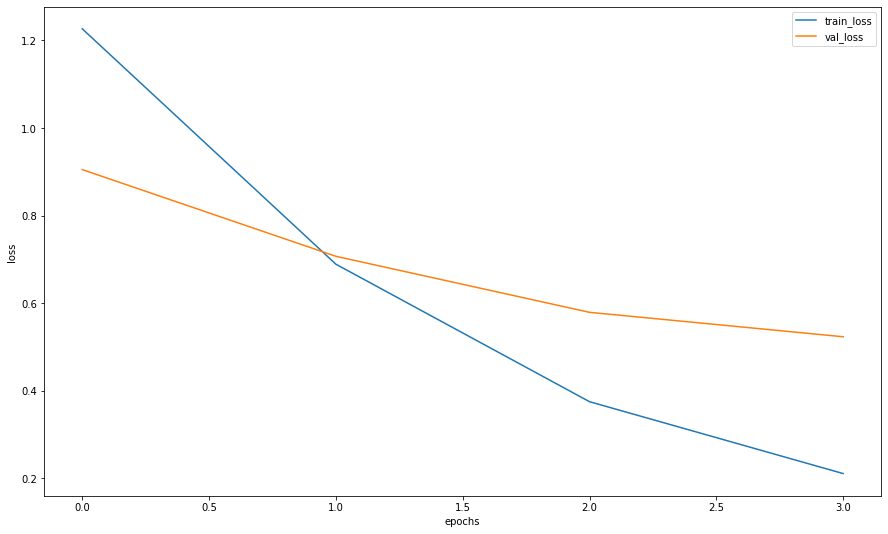

In [28]:
from sklearn.model_selection import StratifiedKFold

n_folds = 10 # Тренируем 10 моделей (на своих подвыборках)
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(train_val_files_, label_encoder.transform(train_val_labels_))):
    print('\nFOLD', fold+1)
    val_dataset = SimpsonsDataset(np.array(train_val_files_)[val_idx], mode='val')
    train_dataset = SimpsonsDataset(np.array(train_val_files_)[train_idx], mode='train')
    
    model = ConvModel(n_classes).to(DEVICE)
    history = train(train_dataset, val_dataset, model=model, epochs=EPOCHS, batch_size=BATCH_SIZE)
    
    loss, acc, val_loss, val_acc = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()
    plt.close()
    
    probs = predict(model, test_loader)
    preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
    
    submit[f'fold_{fold+1}'] = preds

In [29]:
test_filenames = [path.name for path in test_dataset.files]
submit['Id'] = test_filenames
submit.head(50)

,Id,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6,fold_7,fold_8,fold_9,fold_10
0,img0.jpg,nelson_muntz,nelson_muntz,nelson_muntz,nelson_muntz,nelson_muntz,nelson_muntz,nelson_muntz,nelson_muntz,nelson_muntz,nelson_muntz
1,img1.jpg,bart_simpson,bart_simpson,bart_simpson,bart_simpson,bart_simpson,bart_simpson,bart_simpson,bart_simpson,bart_simpson,bart_simpson
2,img10.jpg,ned_flanders,ned_flanders,ned_flanders,ned_flanders,ned_flanders,ned_flanders,ned_flanders,ned_flanders,ned_flanders,ned_flanders
3,img100.jpg,chief_wiggum,chief_wiggum,chief_wiggum,chief_wiggum,chief_wiggum,chief_wiggum,chief_wiggum,chief_wiggum,chief_wiggum,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon,apu_nahasapeemapetilon,apu_nahasapeemapetilon,apu_nahasapeemapetilon,apu_nahasapeemapetilon,apu_nahasapeemapetilon,apu_nahasapeemapetilon,apu_nahasapeemapetilon,apu_nahasapeemapetilon,apu_nahasapeemapetilon
5,img102.jpg,kent_brockman,kent_brockman,kent_brockman,kent_brockman,kent_brockman,kent_brockman,kent_brockman,kent_brockman,kent_brockman,kent_brockman
6,img103.jpg,edna_krabappel,edna_krabappel,edna_krabappel,edna_krabappel,edna_krabappel,edna_krabappel,edna_krabappel,edna_krabappel,edna_krabappel,edna_krabappel
7,img104.jpg,chief_wiggum,chief_wiggum,chief_wiggum,chief_wiggum,chief_wiggum,chief_wiggum,chief_wiggum,chief_wiggum,chief_wiggum,chief_wiggum
8,img105.jpg,lisa_simpson,lisa_simpson,lisa_simpson,lisa_simpson,lisa_simpson,lisa_simpson,lisa_simpson,lisa_simpson,lisa_simpson,lisa_simpson
9,img106.jpg,kent_brockman,kent_brockman,kent_brockman,kent_brockman,kent_brockman,kent_brockman,kent_brockman,kent_brockman,kent_brockman,kent_brockman


In [30]:
submit['Expected'] = submit.mode(axis=1)[0] # Ответ - мода среди моделей для каждой картинки

In [31]:
submit.head()

,Id,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6,fold_7,fold_8,fold_9,fold_10,Expected
0,img0.jpg,nelson_muntz,nelson_muntz,nelson_muntz,nelson_muntz,nelson_muntz,nelson_muntz,nelson_muntz,nelson_muntz,nelson_muntz,nelson_muntz,nelson_muntz
1,img1.jpg,bart_simpson,bart_simpson,bart_simpson,bart_simpson,bart_simpson,bart_simpson,bart_simpson,bart_simpson,bart_simpson,bart_simpson,bart_simpson
2,img10.jpg,ned_flanders,ned_flanders,ned_flanders,ned_flanders,ned_flanders,ned_flanders,ned_flanders,ned_flanders,ned_flanders,ned_flanders,ned_flanders
3,img100.jpg,chief_wiggum,chief_wiggum,chief_wiggum,chief_wiggum,chief_wiggum,chief_wiggum,chief_wiggum,chief_wiggum,chief_wiggum,chief_wiggum,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon,apu_nahasapeemapetilon,apu_nahasapeemapetilon,apu_nahasapeemapetilon,apu_nahasapeemapetilon,apu_nahasapeemapetilon,apu_nahasapeemapetilon,apu_nahasapeemapetilon,apu_nahasapeemapetilon,apu_nahasapeemapetilon,apu_nahasapeemapetilon


In [32]:
submit[['Id', 'Expected']].to_csv('submission_4.csv', index=False)